<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/RL_03_04_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50 finished
Epoch 2/50 finished
Epoch 3/50 finished
Epoch 4/50 finished
Epoch 5/50 finished
Epoch 6/50 finished
Epoch 7/50 finished
Epoch 8/50 finished
Epoch 9/50 finished
Epoch 10/50 finished
Epoch 11/50 finished
Epoch 12/50 finished
Epoch 13/50 finished
Epoch 14/50 finished
Epoch 15/50 finished
Epoch 16/50 finished
Epoch 17/50 finished
Epoch 18/50 finished
Epoch 19/50 finished
Epoch 20/50 finished
Epoch 21/50 finished
Epoch 22/50 finished
Epoch 23/50 finished
Epoch 24/50 finished
Epoch 25/50 finished
Epoch 26/50 finished
Epoch 27/50 finished
Epoch 28/50 finished
Epoch 29/50 finished
Epoch 30/50 finished
Epoch 31/50 finished
Epoch 32/50 finished
Epoch 33/50 finished
Epoch 34/50 finished
Epoch 35/50 finished
Epoch 36/50 finished
Epoch 37/50 finished
Epoch 38/50 finished
Epoch 39/50 finished
Epoch 40/50 finished
Epoch 41/50 finished
Epoch 42/50 finished
Epoch 43/50 finished
Epoch 44/50 finished
Epoch 45/50 finished
Epoch 46/50 finished
Epoch 47/50 finished
Epoch 48/50 finished
E

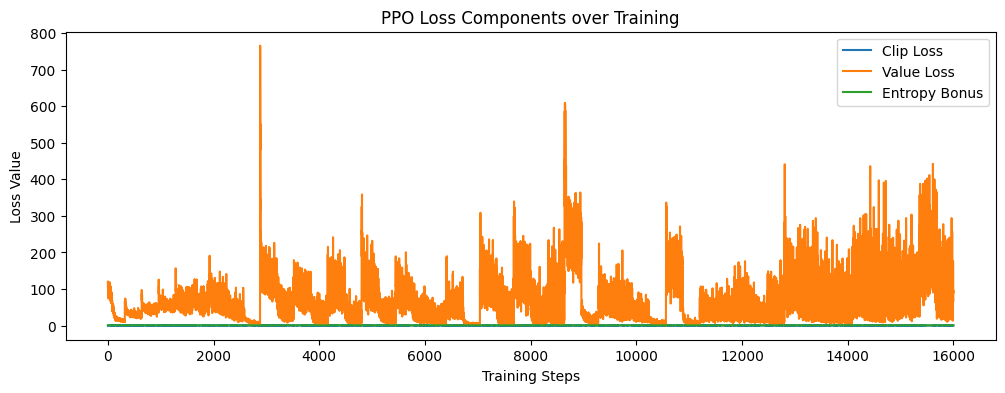

In [1]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# =========================
# 정책 + 가치 네트워크 정의
# =========================
class PPOAgent(tf.keras.Model):
    def __init__(self, action_size):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(64, activation='tanh')
        self.d2 = tf.keras.layers.Dense(64, activation='tanh')
        self.policy_logits = tf.keras.layers.Dense(action_size)   # 정책
        self.value = tf.keras.layers.Dense(1)                     # 가치

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return self.policy_logits(x), self.value(x)

# =========================
# PPO 하이퍼파라미터
# =========================
gamma = 0.99
lam = 0.95
epsilon = 0.2
lr = 0.0005
epochs = 50
update_steps = 2048
mini_batch_size = 64
train_epochs = 10

env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = PPOAgent(action_dim)
optimizer = tf.keras.optimizers.Adam(lr)

# 손실 기록
clip_losses, value_losses, entropy_bonuses = [], [], []

# =========================
# 보상-어드밴티지 계산 함수
# =========================
def compute_gae(rewards, values, dones, last_value):
    advs = []
    gae = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * (1 - dones[i]) * (values[i+1] if i < len(rewards)-1 else last_value) - values[i]
        gae = delta + gamma * lam * (1 - dones[i]) * gae
        advs.insert(0, gae)
    return np.array(advs, dtype=np.float32)

# =========================
# PPO 업데이트 함수
# =========================
def ppo_update(obs_buf, act_buf, old_logp_buf, adv_buf, ret_buf):
    dataset = tf.data.Dataset.from_tensor_slices((obs_buf, act_buf, old_logp_buf, adv_buf, ret_buf))
    dataset = dataset.shuffle(buffer_size=1024).batch(mini_batch_size)

    for _ in range(train_epochs):
        for obs_mb, act_mb, old_logp_mb, adv_mb, ret_mb in dataset:
            with tf.GradientTape() as tape:
                logits, values = agent(obs_mb)
                values = tf.squeeze(values, axis=1)

                # 새로운 정책 확률
                action_probs = tf.nn.softmax(logits)
                new_logp = tf.math.log(tf.reduce_sum(action_probs * tf.one_hot(act_mb, action_dim), axis=1) + 1e-10)

                # 확률비
                ratio = tf.exp(new_logp - old_logp_mb)

                # clip loss
                clipped_adv = tf.clip_by_value(ratio, 1-epsilon, 1+epsilon) * adv_mb
                clip_loss = -tf.reduce_mean(tf.minimum(ratio * adv_mb, clipped_adv))

                # value loss
                value_loss = tf.reduce_mean((ret_mb - values) ** 2)

                # entropy bonus
                entropy = -tf.reduce_mean(tf.reduce_sum(action_probs * tf.math.log(action_probs + 1e-10), axis=1))

                loss = clip_loss + 0.5 * value_loss - 0.01 * entropy

            grads = tape.gradient(loss, agent.trainable_variables)
            optimizer.apply_gradients(zip(grads, agent.trainable_variables))

            # 손실 기록
            clip_losses.append(clip_loss.numpy())
            value_losses.append(value_loss.numpy())
            entropy_bonuses.append(entropy.numpy())

# =========================
# 학습 루프
# =========================
for epoch in range(epochs):
    obs_buf, act_buf, rew_buf, val_buf, logp_buf, done_buf = [], [], [], [], [], []
    obs, _ = env.reset()
    done = False

    for step in range(update_steps):
        obs_tf = tf.convert_to_tensor(obs.reshape(1, -1), dtype=tf.float32)
        logits, value = agent(obs_tf)
        action_probs = tf.nn.softmax(logits)
        action = np.random.choice(action_dim, p=action_probs.numpy()[0])
        logp = np.log(action_probs[0, action].numpy() + 1e-10)

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # 버퍼에 저장
        obs_buf.append(obs)
        act_buf.append(action)
        rew_buf.append(reward)
        val_buf.append(value.numpy()[0,0])
        logp_buf.append(logp)
        done_buf.append(float(done))

        obs = next_obs
        if done:
            obs, _ = env.reset()

    # GAE 계산
    obs_tf = tf.convert_to_tensor(obs.reshape(1, -1), dtype=tf.float32)
    _, last_val = agent(obs_tf)
    adv_buf = compute_gae(rew_buf, val_buf, done_buf, last_val.numpy()[0,0])
    ret_buf = adv_buf + np.array(val_buf)

    # PPO 업데이트
    ppo_update(
        tf.convert_to_tensor(np.array(obs_buf), dtype=tf.float32),
        tf.convert_to_tensor(np.array(act_buf), dtype=tf.int32),
        tf.convert_to_tensor(np.array(logp_buf), dtype=tf.float32),
        tf.convert_to_tensor((adv_buf - adv_buf.mean()) / (adv_buf.std() + 1e-8), dtype=tf.float32),
        tf.convert_to_tensor(ret_buf, dtype=tf.float32)
    )

    print(f"Epoch {epoch+1}/{epochs} finished")

env.close()

# =========================
# 손실 시각화
# =========================
plt.figure(figsize=(12,4))
plt.plot(clip_losses, label="Clip Loss")
plt.plot(value_losses, label="Value Loss")
plt.plot(entropy_bonuses, label="Entropy Bonus")
plt.legend()
plt.title("PPO Loss Components over Training")
plt.xlabel("Training Steps")
plt.ylabel("Loss Value")
plt.show()
